# Business Problem

We are _Best Film Recommenders (BFR)_, a company located in NYC and founded by two Columbia Students in 2014. Since our inception, we have been recognized by our users for our accurate and personalized movie recommendations. However, our industry is always evolving, requiring constant improvements to remain competitive and profitable.

A week ago we received a letter from _Wes Anderson Productions (WAP)_, the company which owns the rights for every movie directed by Wes Anderson. Within the letter they claim that despite the high quality of Wes Anderson's films, most of his work is still unknown by most consumers. The only exceptions are _The Grand Budapest Hotel (2014)_ (which received critical acclaim, including nine Oscars nominations), and _Isle of Dogs (2018)_, which popularity was boosted by the former's success.

Due to WAP films having high ratings yet low viewership, the company believes that six of Wes Anderson's films are unpopular due to a lack of publicity when they were released. With the Christmas season approaching, WAP believe that target advertising can bring in new viewers that never knew the movies existed, increasing revenue from movie sales. For this reason, WAP are willing to pay a significant sum of money if we can reach 1,000 users, representing a significant potential income for our company.

While we could recommend the six movies to all our users, our company's mission has always been focussed on our users, and we don't want to make recommendations they can find irrelevant. Because of this, we would like to find the movie which is most likely to be enjoyed by each user among the following films: 

* _Rushmore (1998)_
* _The Royal Tenenbaums (2001)_
* _The Life Aquatic with Steve Zissou (2004)_
* _The Darjeeling Limited (2007)_
* _Fantastic Mr. Fox (2009)_
* _Moonrise Kingdom (2012)_

Therefore, our goal will be to build a new _Wes Anderson Recommendation System (WARS)_, to find the ideal movie per user. While we have no _accuracy cutoff_, we want our recommendations to be as targeted as possible to keep a high availability of advertising space, should new clients wish to use our services.

# Phase 1

In this initial phase our goal is to play with the data so that we have a clearer idea of which route to take in building a robust final product.

To maximize the breadth of our training, we will design datasets with different characteristics, try different kinds of recommendation techniques, and fit the models by shifting several hyperparameters. All with the intention to find what works and what doesn't for the first release of _WARS_.

## Data

Similar to our previous recommendation systems, we are going to use subsets of the full data set for education and development from [MovieLens](https://grouplens.org/datasets/movielens/). 

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import collections

In [11]:
df_ratings = pd.read_csv('movie_data/ratings.csv')
df_movies = pd.read_csv('movie_data/movies.csv')
df_tags = pd.read_csv('movie_data/tags.csv')
df_genome_scores = pd.read_csv('movie_data/genome-scores.csv')
df_genome_tags = pd.read_csv('movie_data/genome-tags.csv')
df_genome = pd.merge(df_genome_scores, df_genome_tags, on='tagId', how='inner')

From previous experience we know that people can change their preferences and opinions over time. Therefore, to ensure the quality of our data, we will use only ratings given since 2016.

In [12]:
def get_year(ts):
    return datetime.fromtimestamp(int(ts)).year

df_ratings['year'] = df_ratings['timestamp'].apply(get_year)
min_year = 2016
df_ratings = df_ratings[df_ratings.year >= min_year][['userId', 'movieId', 'rating']]

Before we start, let's confirm or deny the _WAP_'s hypothesis: Are the six proposed movies truly unpopular, but good?

To do that, let's count the number of total opinions, and the average rating of all the movies in the dataset, and then compare them with the _WAP_ movies.

In [13]:
df_movies = df_ratings.groupby(['movieId']).agg({'rating':['count', np.mean]}).rating

In [14]:
wap_movies = np.array([2395, 4979, 30810, 55269, 72226, 94959])

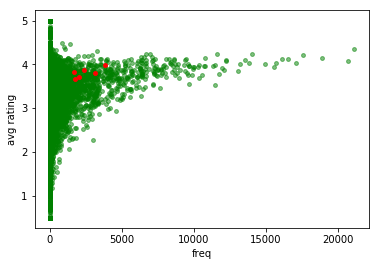

In [15]:
x = df_movies['count']
y = df_movies['mean']
x_wap = df_movies[df_movies.index.isin(wap_movies)]['count']
y_wap = df_movies[df_movies.index.isin(wap_movies)]['mean']

plt.scatter(x, y, c="green", alpha=0.5, s=15)
plt.scatter(x_wap, y_wap, c="red", s=15)
plt.xlabel("freq")
plt.ylabel("avg rating")
plt.show()

In [ ]:
def get_genres_dict(df_movies):
    genres_values = df_movies['genres'].map(lambda x: x.split('|')).values
    genres = list(set(
        [genre for movie_genres in genres_values for genre in movie_genres if genre != "(no genres listed)"]
    ))
    genres_dict = {genres[i]: i for i in range(0,len(genres))}
    return(genres_dict)

def get_popular_tags_dict(df_tags, number):
    df_popular_tags = df_tags.groupby('tag').userId.count().reset_index()\
        .sort_values(by=['userId'], ascending=False)\
        .head(number)
    popular_tags = df_popular_tags['tag'].values
    pop_tags_dict = {popular_tags[i]: i for i in range(0,len(popular_tags))}
    return(pop_tags_dict)

def get_relevant_tags_dict(df_genome, number):
    df_relevant_tags = df_genome.groupby('tag').relevance.mean().reset_index()\
        .sort_values(by=['relevance'], ascending=False)\
        .head(number)
    relevant_tags = df_relevant_tags['tag'].values
    rel_tags_dict = {relevant_tags[i]: i for i in range(0,len(relevant_tags))}
    return(rel_tags_dict)

genres_dict = get_genres_dict(df_movies)
pop_tags_dict = get_popular_tags_dict(df_tags, 150)
rel_tags_dict = get_relevant_tags_dict(df_genome, 150)

### User Features

#### Total movies / Genres features

In [ ]:
def user_movie_genres(df_ratings, df_movies, genres_dict):
    df_user_genres_list = genres_list_per_user(df_ratings, df_movies)
    df_user_total_movies = total_movies_per_user(df_ratings)
    df_user_movies_genres = genres_features_per_user(df_user_genres_list, df_user_total_movies, genres_dict)
    total_movies = len(pd.unique(df_ratings.movieId))
    df_user_movies_genres['movies_perc'] = df_user_movies_genres.total_movies / total_movies
    df_user_movies_genres = df_user_movies_genres[['userId', 'movies_perc', 'genres_features']]
    return(df_user_movies_genres)

def genres_list_per_user(df_ratings, df_movies):
    df_ratings_movies = pd.merge(df_ratings, df_movies, on='movieId', how='left')
    df_ratings_movies['genres_list'] = df_ratings_movies['genres'].apply(lambda x:x.split('|'))
    df_user_genres_list = df_ratings_movies\
        .groupby('userId')\
        .genres_list\
        .apply(lambda x:[genre for genres in x for genre in genres])\
        .reset_index()
    return(df_user_genres_list)

def total_movies_per_user(df_ratings):
    df_user_total_movies = df_ratings.groupby('userId').movieId.count().reset_index()
    df_user_total_movies.rename(columns={'movieId':'total_movies'}, inplace=True)
    return(df_user_total_movies)

def genres_features_per_user(df_user_genres_list, df_user_total_movies, genres_dict):
    df_user_movies_genres = pd.merge(df_user_genres_list, df_user_total_movies, on='userId', how='inner')
    df_user_movies_genres['genres_features'] = df_user_movies_genres\
        .apply(lambda x: get_user_genres_features(x['genres_list'], x['total_movies'], genres_dict), axis=1)
    return(df_user_movies_genres)

def get_user_genres_features(genres_list, total_movies, genres_dict):
    genres_num = len(genres_dict)
    genres_features = [0.0] * genres_num
    genres_list = [genre for genre in genres_list if genre != "(no genres listed)"]
    genres_freq = collections.Counter(genres_list)
    for genre, freq in genres_freq.items():
        genres_features[genres_dict[genre]] = freq / total_movies
    return(genres_features)

df_user_movies_genres = user_movie_genres(df_ratings, df_movies, genres_dict)
df_user_movies_genres.head(6)

#### Popular Tags Features

In [ ]:
def user_tags(df_ratings, df_tags, pop_tags_dict):
    df_user_tags_list = tags_list_per_user(df_ratings, df_tags)
    df_user_tags = tags_features_per_user(df_user_tags_list)
    return(df_user_tags)

def tags_list_per_user(df_ratings, df_tags):
    df_tags.rename(columns={'timestamp':'tag_timestamp'}, inplace=True)
    df_ratings_tags = pd.merge(df_ratings, df_tags, on=['userId','movieId'], how='left')
    df_user_tags_list = df_ratings_tags\
        .groupby('userId')\
        .tag\
        .apply(lambda x: [tag for tag in x if tag is not np.nan])\
        .reset_index()
    df_user_tags_list.rename(columns={'tag':'tags_list'}, inplace=True)
    return(df_user_tags_list)

def tags_features_per_user(df_user_tags_list):
    df_user_tags_list['tags_features'] = df_user_tags_list\
        .apply(lambda x: get_user_tags_features(x['tags_list'], pop_tags_dict), axis=1)
    df_user_tags = df_user_tags_list[['userId', 'tags_features']]
    return(df_user_tags)

def get_user_tags_features(tags_list, pop_tags_dict):
    tags_num = len(pop_tags_dict)
    tags_features = [0.0] * tags_num
    pop_tags_list = [tag for tag in tags_list if tag in pop_tags_dict.keys()]
    tags_freq = collections.Counter(pop_tags_list)
    for tag, freq in tags_freq.items():
        tags_features[pop_tags_dict[tag]] = freq / len(tags_list)
    return(tags_features)

df_user_tags = user_tags(df_ratings, df_tags, pop_tags_dict)
df_user_tags.head(6)

#### Merge features

In [ ]:
def user_features(df_ratings, df_movies, df_tags, genres_dict, pop_tags_dict):
    df_user_movies_genres = user_movie_genres(df_ratings, df_movies, genres_dict)
    df_user_tags = user_tags(df_ratings, df_tags, pop_tags_dict)
    df_user_mgt = pd.merge(df_user_movies_genres, df_user_tags, on='userId', how='inner')
    df_user_mgt['features_m'] = df_user_mgt.apply(lambda x: [x['movies_perc']], axis=1)
    df_user_mgt['features_mg'] = df_user_mgt.\
            apply(lambda x: [x['movies_perc']] + x['genres_features'], axis=1)
    df_user_mgt['features_mgt'] = df_user_mgt.\
            apply(lambda x: [x['movies_perc']] + x['genres_features'] + x['tags_features'], axis=1)
    df_user_features = df_user_mgt[['userId','features_m','features_mg','features_mgt']]
    return(df_user_features)

df_user_features = user_features(df_ratings, df_movies, df_tags, genres_dict, pop_tags_dict)
df_user_features.head(5)

### Movie Features

#### Total users features

In [ ]:
def movie_users(df_ratings):
    total_users = len(pd.unique(df_ratings.userId))
    df_movie_users = df_ratings.groupby('movieId').userId.count().reset_index()
    df_movie_users.rename(columns={'userId':'total_users'}, inplace=True)
    df_movie_users['users_perc'] = df_movie_users.total_users / total_users
    df_movie_users = df_movie_users[['movieId', 'users_perc']]
    return(df_movie_users)

df_movie_users = movie_users(df_ratings)
df_movie_users.head(5)

#### Genres Features

In [ ]:
def movie_genres(df_ratings, df_movies, genres_dict):
    df_rating_movies = df_ratings[['movieId']].drop_duplicates(keep='first')
    df_movie_genres = pd.merge(df_rating_movies, df_movies, on='movieId', how='inner')
    df_movie_genres['genres_features'] = df_movie_genres\
        .apply(lambda x: get_movie_genres_features(x['genres'], genres_dict), axis=1)
    df_movie_genres = df_movie_genres[['movieId', 'genres_features']]
    return(df_movie_genres)

def get_movie_genres_features(genres_str, genres_dict):
    genres_num = len(genres_dict)
    genres_features = [0] * genres_num
    genres_list = [genre for genre in genres_str.split('|') if genre != "(no genres listed)"]
    for genre in genres_list:
        genres_features[genres_dict[genre]] = 1 / len(genres_list)
    return(genres_features)

df_movie_genres = movie_genres(df_ratings, df_movies, genres_dict)
df_movie_genres.head(5)

#### Tags features

In [ ]:
def movie_tags(df_ratings, df_genome, rel_tags_dict):
    df_movie_genome_list = genome_list_per_movie(df_ratings, df_genome)
    df_movie_tags = tags_features_per_movie(df_movie_genome_list, rel_tags_dict)
    return(df_movie_tags)

def genome_list_per_movie(df_ratings, df_genome):
    df_rating_movies = df_ratings[['movieId']].drop_duplicates(keep='first')
    df_movie_genome = pd.merge(df_rating_movies, df_genome, on='movieId', how='inner')
    df_movie_genome_list = df_movie_genome\
        .groupby('movieId')[['tag', 'relevance']]\
        .apply(lambda x:pd.Series({'genome': x.values.tolist()}))\
        .reset_index()
    df_movie_genome_list.rename(columns={'genome':'genome_list'}, inplace=True)
    return(df_movie_genome_list)

def tags_features_per_movie(df_movie_genome_list, rel_tags_dict):
    df_movie_genome_list['tags_features'] = df_movie_genome_list\
        .apply(lambda x: get_rel_tags_features(x['genome_list'], rel_tags_dict), axis=1)
    df_movie_tags = df_movie_genome_list[['movieId', 'tags_features']]
    return(df_movie_tags)

def get_rel_tags_features(genome_list, rel_tags_dict):
    tags_num = len(rel_tags_dict)
    rel_tags_features = [0] * tags_num
    try:
        rel_genome = [genome for genome in genome_list if genome[0] in rel_tags_dict.keys()]
    except:
        rel_genome = []
    if (len(rel_genome) > 0):
        for tag, relevance in rel_genome:
            rel_tags_features[rel_tags_dict[tag]] = relevance
    return(rel_tags_features)

df_movie_tags = movie_tags(df_ratings, df_genome, rel_tags_dict)
df_movie_tags.head(5)

#### Merge Features

In [ ]:
def movie_features(df_ratings, df_movies, df_genome, genres_dict, rel_tags_dict):
    df_movie_users = movie_users(df_ratings)
    df_movie_genres = movie_genres(df_ratings, df_movies, genres_dict)
    df_movie_tags = movie_tags(df_ratings, df_genome, rel_tags_dict)
    df_movie_ug = pd.merge(df_movie_users, df_movie_genres, on='movieId', how='inner')
    df_movie_ugt = pd.merge(df_movie_ug, df_movie_tags, on='movieId', how='inner')

    df_movie_ugt['features_u'] = df_movie_ugt.apply(lambda x: [x['users_perc']], axis=1)
    df_movie_ugt['features_ug'] = df_movie_ugt.\
        apply(lambda x: [x['users_perc']] + x['genres_features'], axis=1)
    df_movie_ugt['features_ugt'] = df_movie_ugt.\
        apply(lambda x: [x['users_perc']] + x['genres_features'] + x['tags_features'], axis=1)
    df_movie_features = df_movie_ugt[['movieId', 'features_u', 'features_ug', 'features_ugt']]
    return(df_movie_features)

df_movie_features = movie_features(df_ratings, df_movies, df_genome, genres_dict, rel_tags_dict)
df_movie_features.head(5)

Watching the red points (_WAP_ movies), they are up to the left. In other words, the six proposed movies seem to be unpopular, but good, confirming the hypothesis.

### WAP ratings dataset

Our first idea for the model dataset is to use as items only the six _WAP_ proposed movies. Since now, we will call this, the `wap_ratings` dataset.

In [ ]:
df_wap_ratings = df_ratings_since[df_ratings_since.movieId.isin(wap_movies)]

### Target ratings dataset

However, working with only six items could be insufficient for a recommendation system. Then, we can add other movies with the same unpopular-but-good situation, build a more general recommendation system, and test if it improves our results. Since now, we will call this kind of films, _target movies_.

To be more specific, we will define a _target movie_ as one with between 1500 and 4000 opinions since 2015, and an average rating greater or equal than 3.6.

In [ ]:
from matplotlib.patches import Rectangle
plt.scatter(x, y, c="green", alpha=0.5, s=10)
plt.scatter(x_wap, y_wap, c="red", s=10)
ax = plt.gca()
ax.add_patch(Rectangle((1500, 3.6), 2500, 0.8, color='b', alpha=0.3))
plt.xlabel("freq")
plt.ylabel("avg rating")
plt.show()

As we mentioned before, the idea for _Phase 1_ is to test different approaches. Then, we want to keep the development dataset compact to reduce computational complexity. Because of that, we will use 40 random _target_ movies for the `target_ratings` dataset.

In [ ]:
np.random.seed(2018)

In [ ]:
similar_movies_filter = (df_movies['count'] >= 1500) & (df_movies['count'] <= 4000) &\
    (df_movies['mean'] >= 3.6) & (~df_movies.index.isin(wap_movies))
similar_movies = df_movies[similar_movies_filter].index
m_sample_size = 40
similar_movies_sampled = np.random.choice(similar_movies, m_sample_size)
target_movies = np.concatenate((wap_movies, similar_movies_sampled))
df_target_ratings = df_ratings_since[df_ratings_since.movieId.isin(target_movies)]

### Mixed ratings dataset

Until now, we have two datasets: `wap_ratings`, with the six _WAP_ proposed films, and `target_ratings`, that contains all the movies from the former, adding more random unpopular-but-good movies. But, what if we are missing relevant information from other kinds of films? 

Let's build a third dataset: `mixed_ratings`. It will add to `target_ratings` films at least as popular as the previous ones (more than 1500 opinions since 2015), but which are not considered _target_, maybe because they have more than 4000 opinions, or their average rating is lower than 3.6.  

Again, to keep the dataset simple, we will add only 50 films.

In [ ]:
not_target_movies = np.setdiff1d(df_movies[df_movies['count'] >= 1500].index, target_movies)
m_sample_size = 50
not_target_movies_sampled = np.random.choice(not_target_movies, m_sample_size)
mixed_movies = np.concatenate((target_movies, not_target_movies_sampled))
df_mixed_ratings = df_ratings_since[df_ratings_since.movieId.isin(mixed_movies)]

### Users selection

As we mentioned before, the idea for this phase is to test several different approaches and compare them, to know which one we can go deeper into. Then, to have a fair comparison, we will work with the same users for the three datasets. Since the `wap_ratings` is a subset of the other two, we are going to select users who have rated at least one of the _WAP_ films, assuming the cost of the bias in which we are incurring. Therefore, in the three datasets, all the users will have rated at least two of the WAP films.

In [ ]:
df_wap_ratings = df_ratings_since[df_ratings_since.movieId.isin(wap_movies)]
counts = df_wap_ratings['userId'].value_counts()
user_subset = df_wap_ratings[df_wap_ratings.userId.isin(counts.index[counts > 1])].userId.unique().tolist()
df_wap_ratings = df_wap_ratings[df_wap_ratings.userId.isin(user_subset)]
df_target_ratings = df_target_ratings[df_target_ratings.userId.isin(user_subset)]
df_mixed_ratings = df_mixed_ratings[df_mixed_ratings.userId.isin(user_subset)]

In [ ]:
print("Number of ratings (WAP): " + str(len(df_wap_ratings)))
print("Number of ratings (Target): " + str(len(df_target_ratings)))
print("Number of ratings (Mixed): " + str(len(df_mixed_ratings)))

## Model selection

### Train/Test Split

In [ ]:
# TODO: Describe split train_test 

In [ ]:
df_test_set = df_wap_ratings.sample(frac = 1.0).groupby('userId').head(1).sample(frac = 0.40)
df_wap_ratings_train = pd.concat([df_wap_ratings, df_test_set]).drop_duplicates(keep=False)
df_target_ratings_train = pd.concat([df_target_ratings, df_test_set]).drop_duplicates(keep=False)
df_mixed_ratings_train = pd.concat([df_mixed_ratings, df_test_set]).drop_duplicates(keep=False)

### Surprise Library

In [ ]:
# TODO: Brief description of the library's objectives, specs, developers, etc.

In [ ]:
from surprise import Reader, Dataset, model_selection
from surprise.model_selection import train_test_split

def create_surprise_ratings(df_ratings):
    reader = Reader(rating_scale=(0.5, 5.0))
    sp_ratings = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
    return sp_ratings

In [ ]:
sp_wap_ratings_train = create_surprise_ratings(df_wap_ratings_train)
sp_target_ratings_train = create_surprise_ratings(df_target_ratings_train)
sp_mixed_ratings_train = create_surprise_ratings(df_mixed_ratings_train)
sp_test_set = create_surprise_ratings(df_test_set)

### Accuracy Metrics 

Fraction of Concordant Pairs (FCP) is an error measure proposed in Collaborative Filtering on Ordinal User Feedback by Koren and Sill, and which is already implemented in surprise.

Given a test set, the number of concordant pairs ($n_{c}^{u}$) for user $u$ is defined as the amount of pairs ranked correctly by rating predictor $\hat{r}_u$. In mathematical terms,

$$n_{c}^{u} = |\{(i, j) | \hat{r}_{ui} > \hat{r}_{uj} \text{ and } r_{ui} > r_{uj}\}|.$$
On the other side, the number of discordant pairs are the ones which were misranked:

$$n_{d}^{u} = |\{(i, j) | \hat{r}_{ui} \leq \hat{r}_{uj} \text{ and } r_{ui} > r_{uj}\}|.$$
To get the total of concordant and discordant pairs, we just sum among every user.

$$n_c = \sum_{u}n_{c}^{u}$$
$$n_d = \sum_{u}n_{d}^{u}$$

Finally, the $FCP$ error measure is defined as $$FCP = \frac{n_c}{n_c + n_d},$$

where 1.0 means perfect order, and 0.0 means completely wrong order. Then, the higher is $FCP$, the better is the model.

This measure is useful because it tests the accurate order of the values, more than the specific scale. As our problem is an ordinal one, we are going to take this as our __primary accuracy metric__.

Also, we will use the classic RMSE as our __secondary accuracy metric__.

### Grid Environment

In this section we will be determining the best hyperparameters and models to use in our analysis. Firstly, we will use GridSearchCV to find the best hyperparameters (this can be found within the `surprise` model_selection package. After that is complete, we will compare the models to determine the best from each of the baseline, neighborhood and model based techniques. Within neighborhood we tested basic, mean and zscore knn implementations and for model based, we used svd and svd++. Finally, we will use our held out testing set to compare the baseline, neighbourhood and model based approaches, selecting whichever model has the highest relative accuracy (using FCP).

We will also be testing the above process using three different datasets. The `WAP`, `Target` and `Mixed` sets outlined earlier in the report. The goal of this is to determine if adding more information about other films results in signficant performance enhancements.

In [ ]:
from surprise import BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, SVD, SVDpp
cv = 5
measures = ['fcp', 'rmse']

In [ ]:
def fit_grid_models(sp_ratings, cv, measures):
    np.random.seed(2018)
    models = {}
    models['baseline'] = fit_grid_Baseline(sp_ratings, cv, measures)
    models['knn_basic'] = fit_grid_KNN(sp_ratings, cv, measures, 'basic')
    models['knn_means'] = fit_grid_KNN(sp_ratings, cv, measures, 'means')
    models['knn_zscore'] = fit_grid_KNN(sp_ratings, cv, measures, 'zscore')
    models['svd'] = fit_grid_SVD(sp_ratings, cv, measures, 'svd')
    models['svdpp'] = fit_grid_SVD(sp_ratings, cv, measures, 'svdpp')
    return(models)

In [ ]:
def fit_grid_Baseline(sp_ratings, cv, measures, reg_u=[0], reg_i=[0]):
    param_grid = {'bsl_options': {'reg_u': reg_u, 'reg_i': reg_i}}
    gs_Baseline = model_selection.GridSearchCV(BaselineOnly, param_grid, measures=['fcp', 'rmse'], cv=cv)
    gs_Baseline.fit(sp_ratings)
    return(gs_Baseline)

In [ ]:
def fit_grid_KNN(
    sp_ratings, cv, measures, knn,
    user_based=[False], 
    k=[5, 10, 15],
    reg=[0.0001, 0.001, 0.01], 
    sim_name=['pearson', 'pearson_baseline', 'cosine'],
    sim_min_support=[2, 4],
    method=['als']
):
    param_grid = {'bsl_options': {'method': method,
                              'reg': reg},
              'k': k,
              'sim_options': {'name': sim_name,
                              'min_support': sim_min_support,
                              'user_based': user_based}
              }
    knn_methods = {
        'basic': KNNBasic,
        'means': KNNWithMeans,
        'zscore': KNNWithZScore
    }
    gs_KNN = model_selection.GridSearchCV(knn_methods[knn], param_grid, measures=measures, cv=cv)
    gs_KNN.fit(sp_ratings)
    return(gs_KNN)  

In [ ]:
def fit_grid_SVD(
    sp_ratings, cv, measures, svd,
    n_factors=[5, 10, 20],
    lr_all=[0.001, 0.01, 0.1],
    reg_all=[0.001, 0.01, 0.1]
):
    param_grid = {'n_factors': n_factors, 'lr_all': lr_all, 'reg_all': reg_all}
    svd_methods = {
        'svd': SVD,
        'svdpp': SVDpp
    }
    gs_SVD = model_selection.GridSearchCV(svd_methods[svd], param_grid, measures=measures, cv=cv)
    gs_SVD.fit(sp_ratings)
    return(gs_SVD)

In [ ]:
def print_grid_models_accuracy(models):
    print('FCP metric')
    for model in models.keys():
        print(str(model) + " accuracy: " + str(round(models[model].best_score['fcp'], 4)))

### Grid Models Fitting

In this section we test the accuracy of each model on each dataset after tuning the hyperparameters. This stage is crucial as a preliminary stage between creating a singular baseline model and determining the final model type, parameters, and data subset to use. By testing small chunks of data we can speed up this process and focus the bulk of our time on only the top models and data.

In [ ]:
%%capture
wap_models = fit_grid_models(sp_wap_ratings_train, cv, measures)

In [ ]:
print_grid_models_accuracy(wap_models)

In [ ]:
%%capture
target_models = fit_grid_models(sp_target_ratings_train, cv, measures)

In [ ]:
print_grid_models_accuracy(target_models)

In [ ]:
%%capture
mixed_models = fit_grid_models(sp_mixed_ratings_train, cv, measures)

In [ ]:
print_grid_models_accuracy(mixed_models)

### Final model

In [ ]:
from surprise import accuracy
from collections import defaultdict
from six import iteritems

After finding the correspondent hyperparameters, we will take the neighborhood-based and model-based techniques with the best scores for each `train dataset`, and test them with the real `test set`. 

Compared with the hyperparameters section, where for simplicity we just used the `surprise` implemented methods, in this final model selection we are going to make some changes so that we are able to conduct a fair comparison between the datasets.

Firstly, instead of doing cross-validation, we are going to use a dataset `test_set` which is entirely different from any of the data within the training set.

Secondly, we are not going to calculate the accuracy metric for the entire dataset. Conversely, even when we train the model with several films, we will figure the FCP just taking into account the WAP movies, as this is the core business function of our new recommendation system.

Finally, we were suspicious about the FCP values we were getting from the `surprise` method. After inspecting the original code, we realized it is not implemented exactly as the paper defined it. We believe the implemented method is useful to choose the hyperparameters because the main difference is located within the handling of scale. However, for this section, we decided to code ours with some modifications so that it can be interpreted as the one proposed on the paper and that we described previously in this document.

To achieve this changes, we propose the following functions.

In [ ]:
def fcp_wap(predictions_train, predictions_test):
    """Modified FCP function for the WAP movies, and implementing the paper's definition.
    Args:
        predictions_train (:obj:`list` of :obj:`Prediction\
            <surprise.prediction_algorithms.predictions.Prediction>`):
            A list of predictions, as returned by the :meth:`test()
            <surprise.prediction_algorithms.algo_base.AlgoBase.test>` method.
        predictions_test (:obj:`list` of :obj:`Prediction\
            <surprise.prediction_algorithms.predictions.Prediction>`):
            A list of predictions, as returned by the :meth:`test()
            <surprise.prediction_algorithms.algo_base.AlgoBase.test>` method.
        verbose: If True, will print computed value. Default is ``True``.
    Returns:
        The Fraction of Concordant Pairs.
    Raises:
        ValueError: When ``predictions`` is empty.
    """

    if not predictions_test:
        raise ValueError('Prediction list is empty.')

    predictions_u = defaultdict(list)
    nc_u = defaultdict(int)
    nd_u = defaultdict(int)
    fcp_u = defaultdict(float)
    wap_movies = np.array([2395, 4979, 30810, 55269, 72226, 94959])

    for u0, m, r0, est, _ in predictions_train:
        if m in wap_movies:
            predictions_u[u0].append((r0, r0, 'train'))
    
    for u0, m, r0, est, _ in predictions_test:
        if m in wap_movies:
            predictions_u[u0].append((r0, est, 'test'))

    for u0, preds in iteritems(predictions_u):
        for r0i, esti, kindi in preds:
            if kindi == 'test':
                for r0j, estj, kindj in preds:
                    if ((esti > estj and r0i > r0j) or (esti == estj and r0i == r0j)):
                        nc_u[u0] += 1
                    if esti >= estj and r0i < r0j:
                        nd_u[u0] += 1
        try:
            fcp_u[u0] = nc_u[u0] / (nc_u[u0] + nd_u[u0])
        except:
            pass

    fcp = round(np.mean(list(fcp_u.values())), 4)

    return fcp

In [ ]:
def get_test_accuracy(sp_test, sp_train, models, technique):
    algo = models[technique].best_estimator['fcp']
    trainset = sp_train.build_full_trainset()
    testset = sp_test.build_full_trainset()
    algo.fit(trainset)
    predictions_train = algo.test(trainset.build_testset())
    predictions_test = algo.test(testset.build_testset())
    accuracy = fcp_wap(predictions_train, predictions_test)
    return(accuracy)

Below, the three datasets are run through our custom FCP accuracy algorithm using the tuned baseline, knn and svd++ algorithms. Please note that the fcp accuracies have been customized for this given project and should only be used for comparison purposes. They do not represent the overall accuracy in predicting all movies over the entire dataset.

In [ ]:
%%capture
wap_baseline_fcp = get_test_accuracy(sp_test_set, sp_wap_ratings_train, wap_models, 'baseline')
wap_knn_fcp = get_test_accuracy(sp_test_set, sp_wap_ratings_train, wap_models, 'knn_means')
wap_svd_fcp = get_test_accuracy(sp_test_set, sp_wap_ratings_train, wap_models, 'svdpp')

In [ ]:
print('baseline test accuracy: ' + str(wap_baseline_fcp))
print('knn_zscore test accuracy: ' + str(wap_knn_fcp))
print('svdpp accuracy: ' + str(wap_svd_fcp))

In [ ]:
%%capture
target_baseline_fcp = get_test_accuracy(sp_test_set, sp_target_ratings_train, target_models, 'baseline')
target_knn_fcp = get_test_accuracy(sp_test_set, sp_target_ratings_train, target_models, 'knn_means')
target_svd_fcp = get_test_accuracy(sp_test_set, sp_target_ratings_train, target_models, 'svdpp')

In [ ]:
print('baseline test accuracy: ' + str(target_baseline_fcp))
print('knn_means test accuracy: ' + str(target_knn_fcp))
print('svdpp accuracy: ' + str(target_svd_fcp))

In [ ]:
%%capture
mixed_baseline_fcp = get_test_accuracy(sp_test_set, sp_mixed_ratings_train, mixed_models, 'baseline')
mixed_knn_fcp = get_test_accuracy(sp_test_set, sp_mixed_ratings_train, mixed_models, 'knn_zscore')
mixed_svd_fcp = get_test_accuracy(sp_test_set, sp_mixed_ratings_train, mixed_models, 'svdpp')

In [ ]:
print('baseline test accuracy: ' + str(mixed_baseline_fcp))
print('knn_means test accuracy: ' + str(mixed_knn_fcp))
print('svdpp accuracy: ' + str(mixed_svd_fcp))

Even when there was a bias by construction, which we expect helped the `wap ratings` dataset (we selected only users with 2 or more _WAP_ movies ratings, the dataset with the best performance was the `mixed ratings` one. Particularly, we got the best results when we used the svd++ technique.

### Film Selection

What follows from here is to find which is the _WAP_ film with the greatest estimated rating for each user, and send her/him the recommendation. Also, it can be unrealistic to send a recommendation for everybody, because there will be users for which all the _WAP_ movies have low ratings. Then, for further phases of this project, we must set a threshold. Maybe a direct scale rating one, or maybe a minimum quantile among all the estimated movies per customer so that we take into account the scale differences among users.

## Conclusion 

After completing `Phase 1` of our project our team has reached the conclusion that using a larger subset of movies (even those not related to WAP's movies) would be extremely beneficial to the overall accuracy of our model. Also, we have found that the SVD++ model consistently has the highest FCP accuracy of WAP movies as the dataset gains movies. Though our model is still in its infancy the results we have been able to obtain show promise in the potential success that we can obtain by targetting advertisments on behalf of Wes Anderson Productions.

## Future Steps

Due to the time contraints associated with training and testing our models, we were unable to complete certain visualizations that we believe are important to show the client. Therefore, the following will be included in `Phase 2` of our project, when we present our findings with Wes Anderson Productions.
* Create plots of how the error measure changes when we fix all the hyperparameters, except one.
* Get the time it takes to fit each model (on a standard performance VM [ex: aws ec2 t3.large]).
* Since we decided that we will use the complete dataset, we know can recommend _WAP_ movies, even if the user hasn't seen any of them. Then, we can use datasets that reflect this advantage, and we must investigate how this will change the _WARS_ performance.
* Try with recommendation techniques outside the `surprise` package, like 